In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re

headers = re.findall('\s+\w+', """ bytes    packets errs drop fifo frame compressed multicast  bytes    packets errs drop fifo colls carrier compressed""")
headers = [x.strip() for x in headers]
for i in range(len(headers)):
    if i < 8:
        headers[i] = "received-" + headers[i]
    else:
        headers[i] = "sent-" + headers[i]
# print(headers)

def process_line(line):
    d = {}
    if line.split(':')[0].strip() == 'wlan0':
        d['interface'] = 'wlan0'
    elif line.split(':')[0].strip() == 'p2p-wlan0-0':
        d['interface'] = 'p2p-wlan0-0'
    else:
        return None
    line = line.split(':')[1]
    res = re.findall('\s+\w+', line)
    res = [x.strip() for x in res]
    d.update({_[0] : _[1] for _ in zip(headers, res)})

    return pd.DataFrame(d, index=[0])


def create_dataframe(file_path):
    df = pd.DataFrame()
    for line in open(file_path, 'r', encoding='utf-16'):
        new_d = process_line(line)
        if new_d is not None:
            df = pd.concat([df, new_d])

#     df.index.name = 'timestamp'
#     df = df.reset_index()

    df['device'] = file_path.split('\\')[1]
    df['app'] = file_path.split('\\')[2].strip('-W')
    df['app_details'] = file_path.split('\\')[3]
    df['is_record'] = 'record' in file_path.split('\\')[4]
    df['is_wireless'] = '-W' in file_path.split('\\')[2]
    df['repetition'] = file_path.split('\\')[4].strip('record') if 'record' in file_path.split('\\')[4] else file_path.split('\\')[4].strip('replay')

    df.to_csv(f'.\\{file_path.strip(".log")}.csv', index=False)

    return df

def process_network():
    df_aggregated = pd.DataFrame()
    for root, dirs, files in os.walk(".", topdown=False):
        for name in files:
            if name == 'net_dev.log':
                print(os.path.join(root, name))
                df_aggregated = pd.concat([df_aggregated, create_dataframe(os.path.join(root, name))]) 
    # df_aggregated
    return df_aggregated


In [26]:
import warnings
warnings.filterwarnings("ignore")

df = process_network()
df[headers] = df[headers].apply(pd.to_numeric)
# df

.\clumsy-bandwidth-100Mbps\Quest-2\BeatSaber\PopStars-Medium\record1\net_dev.log
.\clumsy-bandwidth-100Mbps\Quest-2\BeatSaber\PopStars-Medium\replay1.0\net_dev.log
.\clumsy-bandwidth-100Mbps\Quest-2\BeatSaber\PopStars-Medium\replay1.1\net_dev.log
.\clumsy-bandwidth-100Mbps\Quest-2\BeatSaber\PopStars-Medium\replay1.2\net_dev.log
.\clumsy-bandwidth-100Mbps\Quest-Pro\BeatSaber\PopStars-Medium\record1\net_dev.log
.\clumsy-bandwidth-100Mbps\Quest-Pro\BeatSaber\PopStars-Medium\replay1.0\net_dev.log
.\clumsy-bandwidth-100Mbps\Quest-Pro\BeatSaber\PopStars-Medium\replay1.1\net_dev.log
.\clumsy-bandwidth-100Mbps\Quest-Pro\BeatSaber\PopStars-Medium\replay1.2\net_dev.log
.\clumsy-bandwidth-30Mbps\Quest-2\BeatSaber\PopStars-Medium\record1\net_dev.log
.\clumsy-bandwidth-30Mbps\Quest-2\BeatSaber\PopStars-Medium\replay1.0\net_dev.log
.\clumsy-bandwidth-30Mbps\Quest-2\BeatSaber\PopStars-Medium\replay1.1\net_dev.log
.\clumsy-bandwidth-30Mbps\Quest-2\BeatSaber\PopStars-Medium\replay1.2\net_dev.log
.\clum

In [27]:
plt.rcParams['font.family'] = 'Arial'
custom_params = {"axes.spines.right": False, 
                 "axes.spines.top": False,
                 "axes.spines.left": True,
                 "axes.spines.bottom": True,
                #create dashes next to ticks
                 "xtick.bottom": True,
                 "ytick.left": True,
                
                 "axes.edgecolor": "black",

                 "axes.grid": True,
                 "axes.linewidth": 1.5, 
                 "axes.facecolor": "white", 
                 "grid.color": "lightgray",
                 
                 }
# custom_params = {}

sns.set_theme(style="whitegrid", rc=custom_params)
sns.set_palette("deep")

custom_mean = {"marker":"d",
                "markerfacecolor":"white", 
                "markeredgecolor":"black",
                "markersize":"7"}

## bandwidth validation

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def to_mbit(bytes):
    return (bytes * 8) / 1048576

# depricated the timestamp was at a second rate anyway.
def dataframe_add_timestamp(file_path : str, df : pd.DataFrame, col_name :str = 'time'):
    with open(file_path, 'r', encoding='utf-16') as file:
        data = []
        for line in file:
            data.append(int(float(line.split(' ')[0])))

        df.insert(0, col_name, data)

def makeFig(limit, device, replay_num, ax):
    sns.set_theme(style="whitegrid", rc=custom_params, font_scale=1.5)

    network_df = pd.read_csv(f"./clumsy-bandwidth-{limit}Mbps/{device}/BeatSaber/PopStars-Medium/replay1.{replay_num}/net_dev.csv")
    
    network_df = network_df[network_df['interface'] == 'wlan0']

    network_df.insert(0, "time",  list(range(len(network_df))))

    network_df['received-mbit'] = network_df['received-bytes'].apply(to_mbit)
    network_df['change'] = network_df['received-mbit'].diff()

    average_change = network_df['change'].sum()/len(network_df['change'])

    data = pd.DataFrame({'time' : network_df['time'], 'change': network_df['change'], 'average': average_change, 'limit': limit })

    palette = sns.color_palette('deep')

    sns.lineplot(ax=ax, x='time', y='change', data=data, label= 'Mbits recieved', palette='deep')

    sns.lineplot(ax=ax, x='time', y='average', data=data, label='Average', color=palette[3], linestyle="--", linewidth=2)
    sns.lineplot(ax=ax, x='time', y='limit', data=data, label='Limit', color=palette[2], linestyle="-.", linewidth=2)

    ax.set(ylabel='Data received [Mbits]', xlabel='Timestamp [s]', title=f'limit = {limit}Mbps')
    ax.text(0, average_change + 1, f'{average_change:.2f}', color='black', fontweight='bold')

    return limit - average_change


In [29]:
def get_network_stats(bandwidth_limit, device):
    df = pd.DataFrame()
    for root, dirs, files in os.walk(f"./clumsy-bandwidth-{bandwidth_limit}Mbps/{device}", topdown=False):
        for name in files:
            if ((name == 'net_dev.csv') and ('replay' in root)):
                print(root)
                df = pd.concat([df, pd.read_csv(os.path.join(root, name))])

    # df = pd.read_csv(f"./clumsy-bandwidth-{bandwidth_limit}Mbps/Quest-Pro/BeatSaber/PopStars-Medium/replay1.0/net_dev.csv")
    df = df[df['interface'] == 'wlan0']
    df.insert(0, "time",  list(range(len(df))))
    df['received-mbit'] = df['received-bytes'].apply(to_mbit)
    df['change'] = df['received-mbit'].diff()
    df['limit_bwith'] = bandwidth_limit
    # average_change = df['change'].sum()/len(df['change'])
    return df

limits = pd.DataFrame()
for limit in [30, 50, 80, 100]:
    # for device in ['Quest-Pro', 'Quest-2']:
    df = get_network_stats(limit, 'Quest-Pro')
    limits = pd.concat([limits, df])

limits = limits.reset_index()

./clumsy-bandwidth-30Mbps/Quest-Pro\BeatSaber\PopStars-Medium\replay1.0
./clumsy-bandwidth-30Mbps/Quest-Pro\BeatSaber\PopStars-Medium\replay1.1
./clumsy-bandwidth-30Mbps/Quest-Pro\BeatSaber\PopStars-Medium\replay1.2
./clumsy-bandwidth-50Mbps/Quest-Pro\BeatSaber\PopStars-Medium\replay1.0
./clumsy-bandwidth-50Mbps/Quest-Pro\BeatSaber\PopStars-Medium\replay1.1
./clumsy-bandwidth-50Mbps/Quest-Pro\BeatSaber\PopStars-Medium\replay1.2
./clumsy-bandwidth-80Mbps/Quest-Pro\BeatSaber\PopStars-Medium\replay1.0
./clumsy-bandwidth-80Mbps/Quest-Pro\BeatSaber\PopStars-Medium\replay1.1
./clumsy-bandwidth-80Mbps/Quest-Pro\BeatSaber\PopStars-Medium\replay1.2
./clumsy-bandwidth-100Mbps/Quest-Pro\BeatSaber\PopStars-Medium\replay1.0
./clumsy-bandwidth-100Mbps/Quest-Pro\BeatSaber\PopStars-Medium\replay1.1
./clumsy-bandwidth-100Mbps/Quest-Pro\BeatSaber\PopStars-Medium\replay1.2


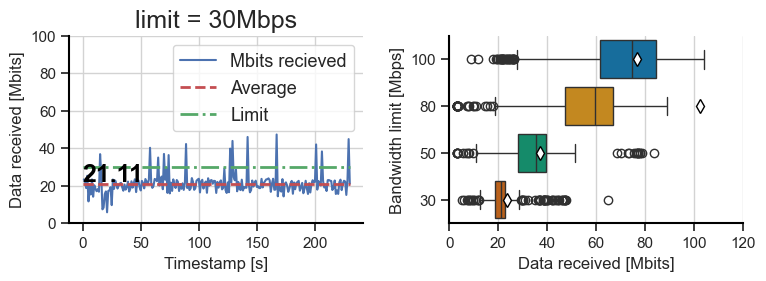

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3.156))
sns.set_theme(style="whitegrid", rc=custom_params, font_scale=1.5)

error0 = makeFig(30, 'Quest-Pro', '0', axes[0])

axes[0].set_yticks([0, 20, 40, 60, 80, 100])
axes[0].set_xticks([0, 50, 100, 150, 200])
axes[0].legend(fontsize=13)

limits['bw_text'] = limits['limit_bwith'].apply(lambda x: 'N/A' if x == 999999 else str(x))
limits.sort_values('limit_bwith', ascending=False, inplace=True)
# fig, ax = plt.subplots(figsize = (8,3))
sns.boxplot(x='change', y='bw_text', data=limits, ax=axes[1], showmeans=True, meanprops=custom_mean, palette='colorblind')
axes[1].set_ylabel('Bandwidth limit [Mbps]')
axes[1].set_xlabel('Data received [Mbits]')
axes[1].set_xticks([0, 20, 40, 60, 80, 100, 120])
axes[1].set_xlim(0, 120)

plt.tight_layout()

plt.savefig('./figures/clumsy-val/mbits-recieved-clumzy-validation-overview.pdf', format='pdf')
plt.show()

## Graph arrays

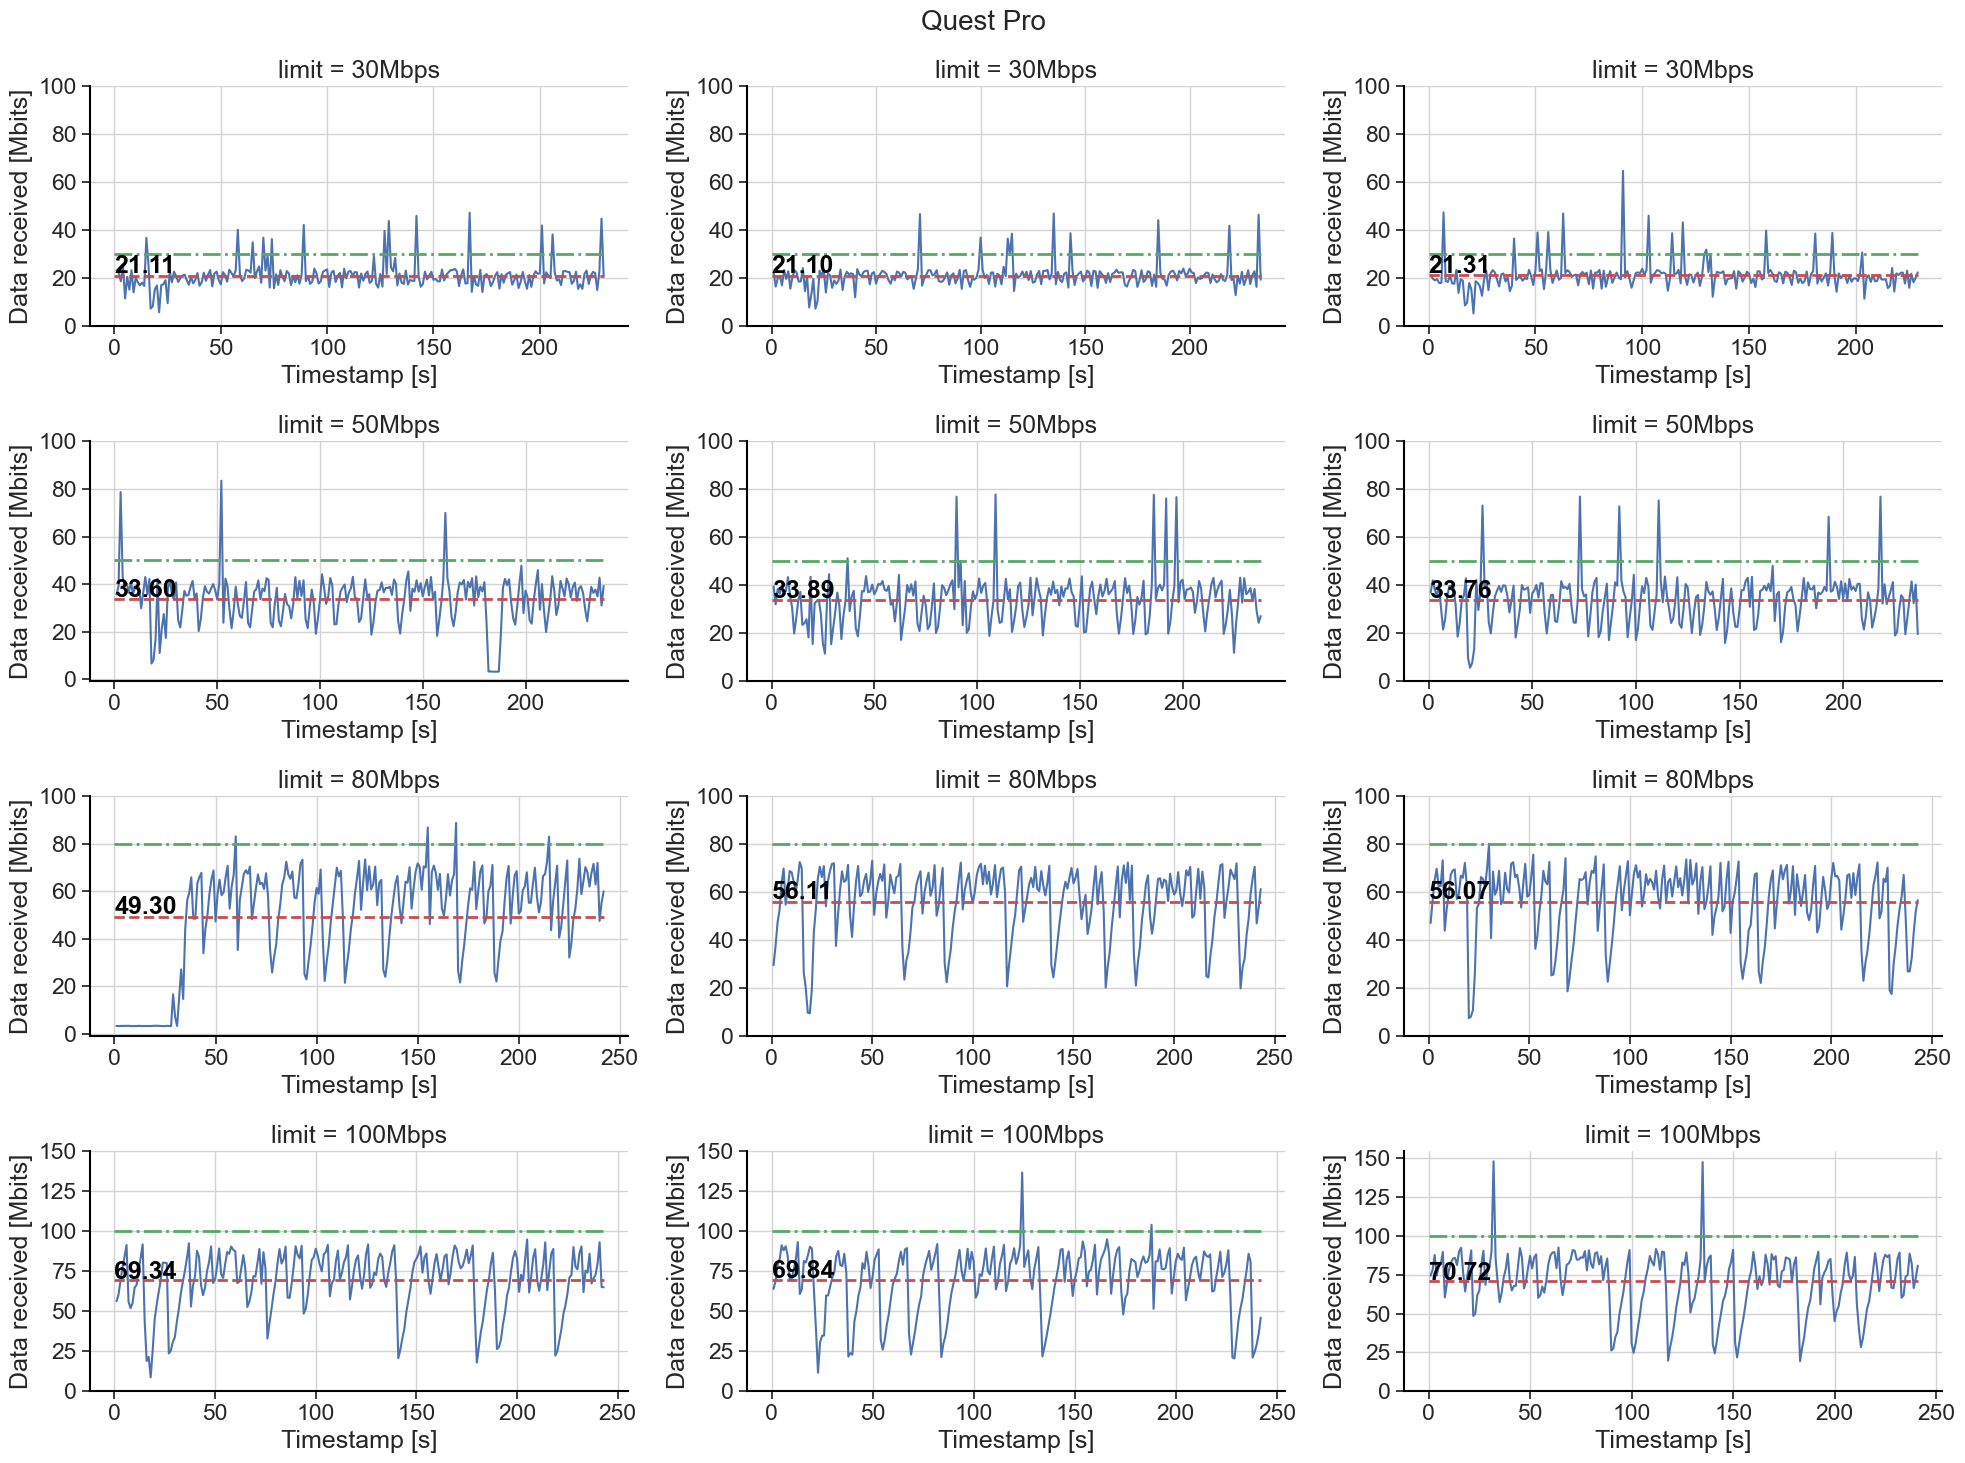

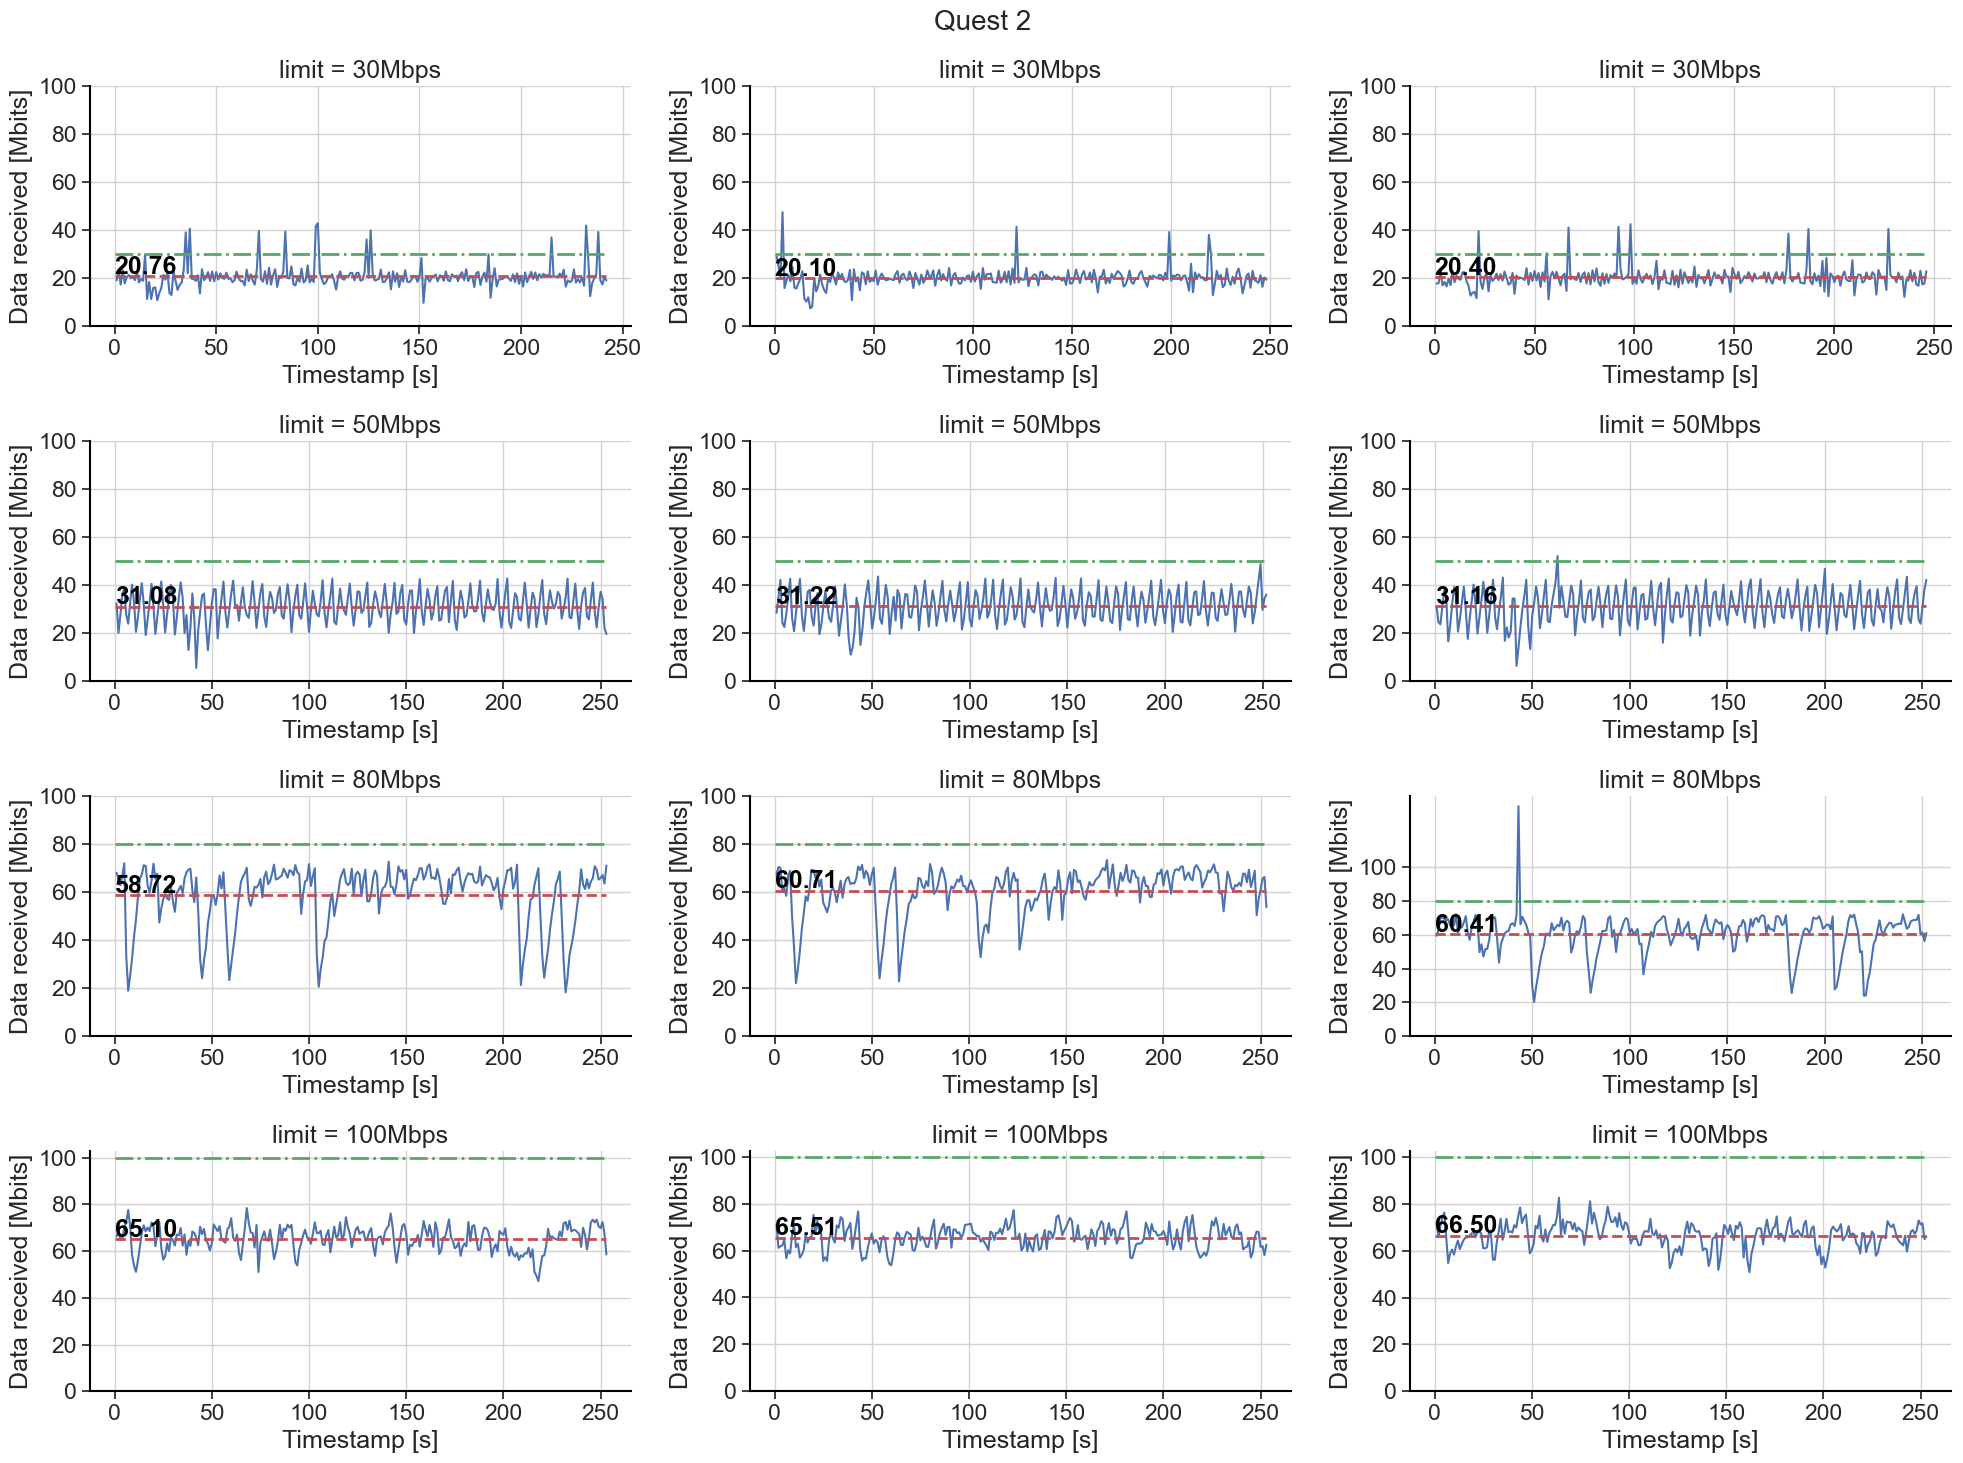

In [31]:
lims = [30, 50, 80, 100]
devices = ['Quest-Pro', 'Quest-2']
replays = ['0', '1', '2']

for device in devices:
    fig, axes = plt.subplots(4, 3, figsize=(20, 15))
    sns.set_theme(style="whitegrid", rc=custom_params, font_scale=1.7)

    for i, limit in zip(range(4), lims):
        for j, replay in zip(range(3), replays):
            error = makeFig(int(limit), device, replay, axes[i][j])

            if limit == 100 and device == 'Quest-Pro':
                axes[i][j].set_yticks([0, 25, 50, 75, 100, 125, 150])
            else:
                axes[i][j].set_yticks([0, 20, 40, 60, 80, 100])
            # axes[i][j].set_yticks([0, 20, 40, 60, 80, 100])
            # axes[i][j].set_xticks([0, 50, 100, 150, 200])
            axes[i][j].get_legend().remove()
    # error0 = makeFig(30, 'Quest-Pro', '0', axes[0])

    # axes[0].set_yticks([0, 20, 40, 60, 80, 100])
    # axes[0].set_xticks([0, 50, 100, 150, 200])
    # axes[0].legend(fontsize=13)

    plt.suptitle(device.replace('-', ' '), fontsize=20)
    plt.tight_layout()
    plt.savefig(f'./figures/bandwidth_exp/{device}_graph_array.pdf', format='pdf')
    plt.show()

## VR device regular network

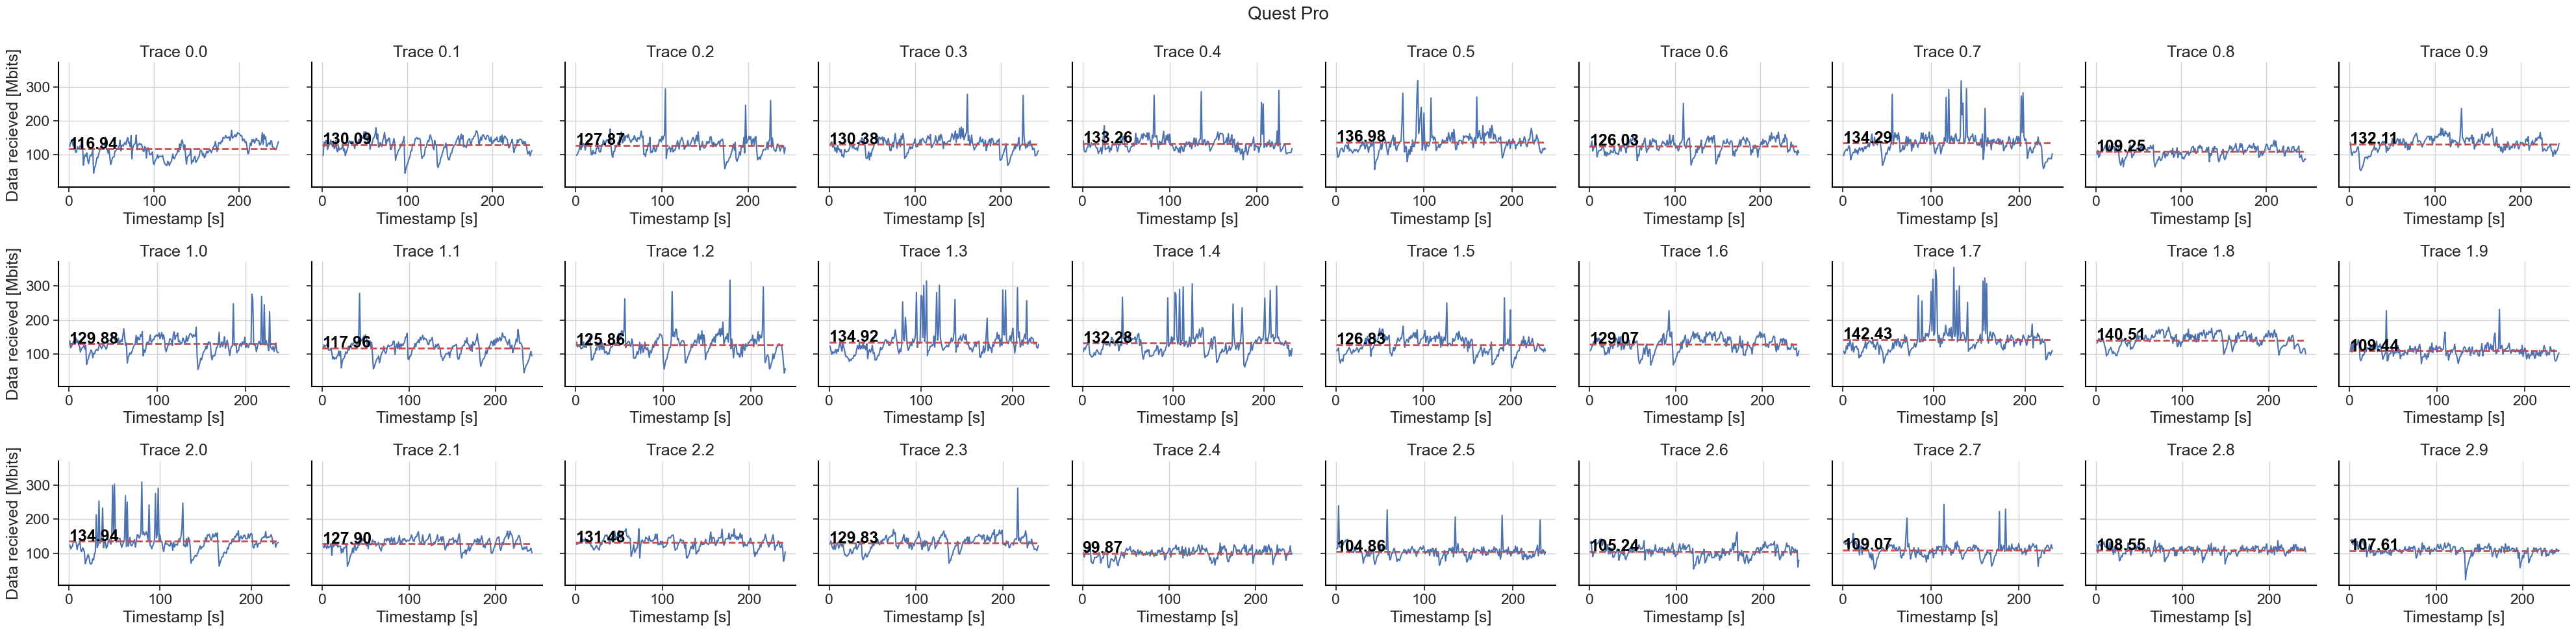

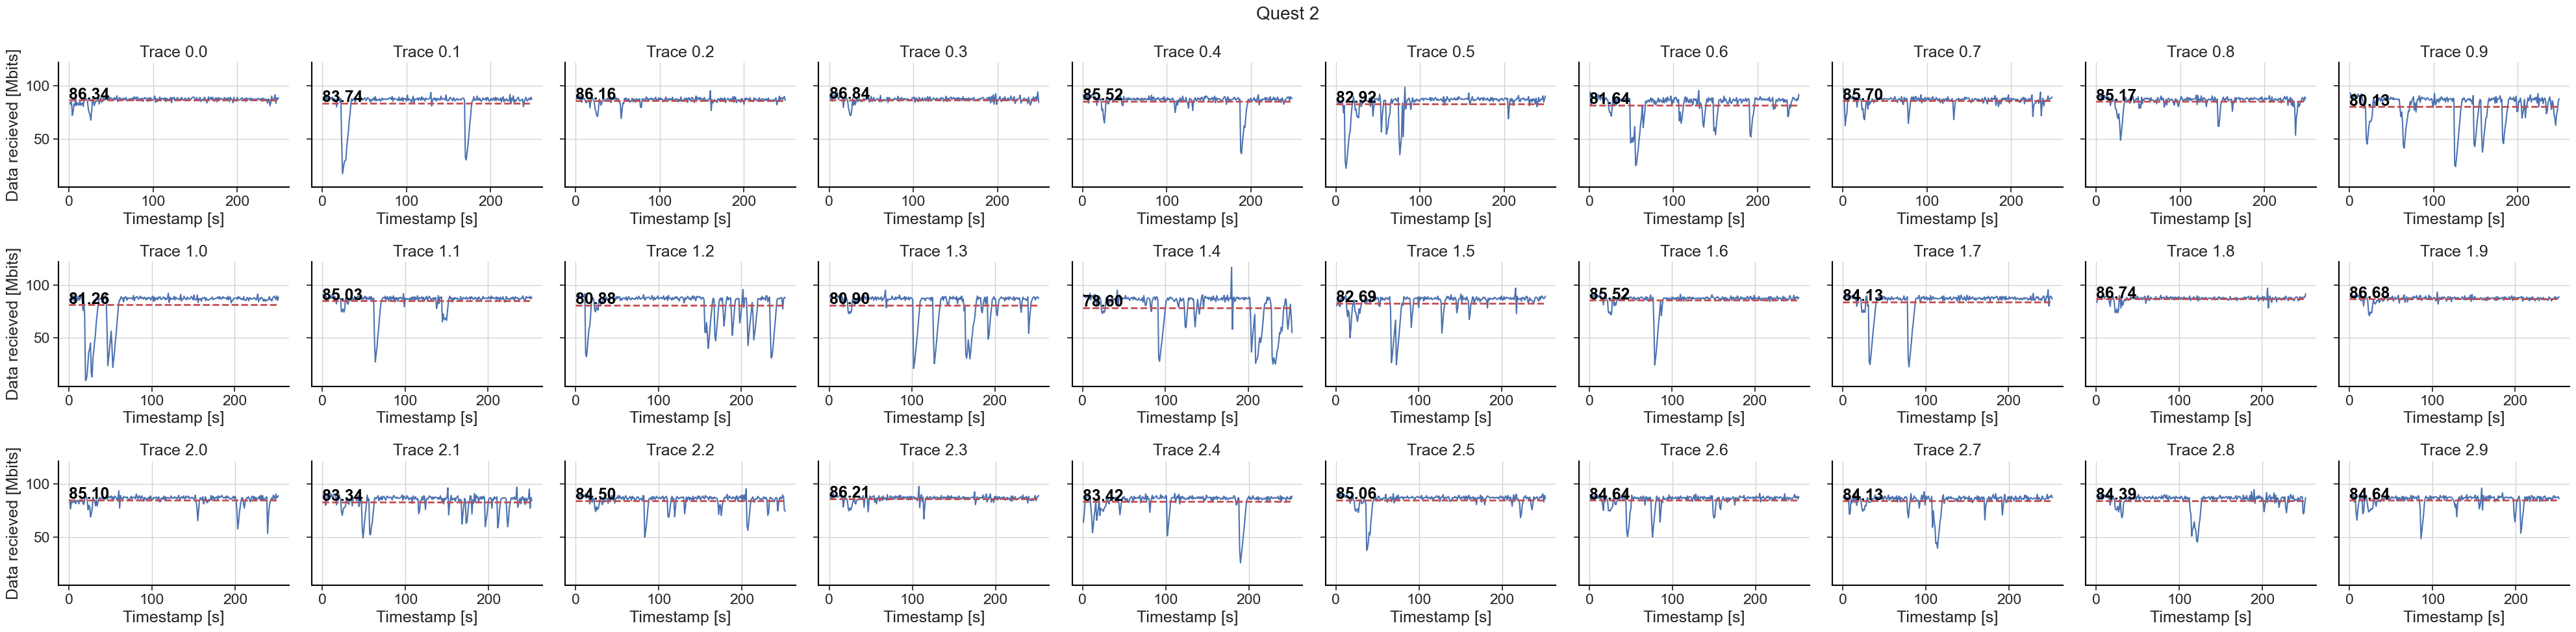

In [8]:
def make_validation_fig(device, record_num, replay_num, ax):
    sns.set_theme(style="whitegrid", rc=custom_params, font_scale=1.5)

    network_df = pd.read_csv(f"./overhead-validation/{device}/BeatSaber/PopStars-Medium/replay{record_num}.{replay_num}/net_dev.csv")
    
    network_df = network_df[network_df['interface'] == 'wlan0']

    network_df.insert(0, "time",  list(range(len(network_df))))

    network_df['received-mbit'] = network_df['received-bytes'].apply(to_mbit)
    network_df['change'] = network_df['received-mbit'].diff()

    average_change = network_df['change'].sum()/len(network_df['change'])

    data = pd.DataFrame({'time' : network_df['time'], 'change': network_df['change'], 'average': average_change})

    palette = sns.color_palette('deep')

    sns.lineplot(ax=ax, x='time', y='change', data=data, label= 'Mbits recieved', palette='deep')

    sns.lineplot(ax=ax, x='time', y='average', data=data, label='Average', color=palette[3], linestyle="--", linewidth=2)

    ax.set(ylabel='Data recieved [Mbits]', xlabel='Timestamp [s]', title=f'Trace {record_num}.{replay_num}')
    ax.text(0, average_change + 1, f'{average_change:.2f}', color='black', fontweight='bold')

    return  average_change

for device in ['Quest-Pro', 'Quest-2']:
    fig, axes = plt.subplots(3, 10, figsize=(40, 10), sharey=True)
    sns.set_theme(style="whitegrid", rc=custom_params, font_scale=1.7)

    for record_num in range(3):
        for replay_num in range(10):
            error = make_validation_fig(device, record_num, replay_num, axes[record_num][replay_num])
            axes[record_num][replay_num].get_legend().remove()
            # axes[record_num][replay_num].set_yticks([0, 20, 40, 60, 80, 100, 120])

    plt.suptitle(device.replace('-', ' '), fontsize=20)
    plt.tight_layout()
    plt.savefig(f'./figures/bandwidth_exp/{device}_validation_network_graph_array.pdf', format='pdf')
    plt.show()

## dropchance validation

0
0
0
0
0
0
0
0
   Set drop chance [%]  Measured drop chance [%]
0                  0.1                       NaN
1                  1.0                       NaN
2                  2.5                       NaN
3                  5.0                       NaN


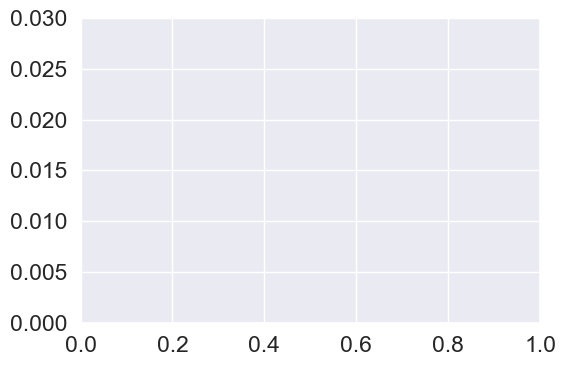

In [9]:
import matplotlib.pyplot as plt

dropchance_001 = df[df['device'] == 'clumsy-dropchance-0.001']
dropchance_010 = df[df['device'] == 'clumsy-dropchance-0.01']
dropchance_025 = df[df['device'] == 'clumsy-dropchance-0.025']
dropchance_050 = df[df['device'] == 'clumsy-dropchance-0.05']

print(dropchance_001['sent-packets'].sum())
print(dropchance_001['sent-drop'].sum())
measure_001 = (dropchance_001['sent-drop'].sum()/(dropchance_001['sent-packets'].sum()+dropchance_001['sent-drop'].sum()))

print(dropchance_010['sent-packets'].sum())
print(dropchance_010['sent-drop'].sum())
measure_010 = (dropchance_010['sent-drop'].sum()/(dropchance_010['sent-packets'].sum()+dropchance_010['sent-drop'].sum()))

print(dropchance_025['sent-packets'].sum())
print(dropchance_025['sent-drop'].sum())
measure_025 = (dropchance_025['sent-drop'].sum()/(dropchance_025['sent-packets'].sum()+dropchance_025['sent-drop'].sum()))

print(dropchance_050['sent-packets'].sum())
print(dropchance_050['sent-drop'].sum())
measure_050 = (dropchance_050['sent-drop'].sum()/(dropchance_050['sent-packets'].sum()+dropchance_050['sent-drop'].sum()))

data = {'Set drop chance [%]' : [0.1, 1, 2.5, 5], 'Measured drop chance [%]' : [measure_001*100, measure_010*100, measure_025*100, measure_050*100] }

data_df = pd.DataFrame(data)

print(data_df)
sns.set_theme(palette= 'deep')
sns.set(font_scale=1.5)

fig, ax = plt.subplots(figsize=(6, 4))
# ax.set_yscale('log')
ax = sns.scatterplot(data=data_df, x='Set drop chance [%]', y='Measured drop chance [%]', palette='deep', color=['black', 'red', 'blue', 'green'], s=200)
# add diagonal line
# ax.plot([0, 5], [0, 5], linewidth=2, color='black', linestyle='--')
plt.xlim(0)
plt.ylim(0, 0.03)

# # inset axes....
# x1, x2, y1, y2 = 0, 5.1, 0, 1  # subregion of the original image
# axins = ax.inset_axes(
#     [0.5, 0.5, 0.47, 0.47],
#     xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
# axins.imshow(data_df, extent=(0, 5, 0, 5), origin="upper")

# ax.indicate_inset_zoom(axins, edgecolor="black")


plt.tight_layout()
plt.savefig('figures/packetloss-validation-weird.pdf', format='pdf', bbox_inches='tight')
plt.show()